In [2]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

In [3]:
from flamingchoripan.files import search_for_filedirs
from lchandler import C_

root_folder = '../../surveys-save'
filedirs = search_for_filedirs(root_folder, fext=C_.EXT_SPLIT_LIGHTCURVE)

────────────────────────────────────────────────────────────────────────────────────────────────────
found filedirs: (../../surveys-save)
(0) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_method-mcmc.splcds - 2.519[mbs]
(1) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_method-linear.splcds - 36.279[mbs]
(2) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_method-bspline.splcds - 36.086[mbs]
(3) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_method-curvefit.splcds - 37.847[mbs]
(4) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_method-uniformprior.splcds - 38.149[mbs]
(5) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe.splcds - 2.212[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────
filedirs after searching with filters: (../../surveys-save)
(0) - ..

In [13]:
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir
from lchandler import C_

def load_lcdataset(filename):
    assert filename.split('.')[-1]==C_.EXT_SPLIT_LIGHTCURVE
    return load_pickle(filename)

method = 'curvefit'
filedir = f'../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_method-{method}.splcds'

filedict = get_dict_from_filedir(filedir)
root_folder = filedict['*rootdir*']
cfilename = filedict['*cfilename*']
survey = filedict['survey']
lcdataset = load_lcdataset(filedir)
print(lcdataset['raw'].keys())
print(lcdataset['raw'].get_random_lcobj(False).keys())
print(lcdataset)

> loading: ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_method-curvefit.splcds
dict_keys(['data', 'survey', 'description', 'band_names', 'class_names', 'obs_is_flux'])
dict_keys(['days', 'obs', 'obse', 'y', 'synthetic'])
LCDataset:
[outliers - samples 8]
(*) obs_samples: 311 - min_len: 8 - max_dur: 408.0[days] - dur(p50): 158.2[days] - cadence(p50): 2.0[days]
(g) obs_samples: 122 - min_len: 0 - max_dur: 408.0[days] - dur(p50): 124.9[days] - cadence(p50): 4.0[days]
(r) obs_samples: 189 - min_len: 1 - max_dur: 376.0[days] - dur(p50): 155.8[days] - cadence(p50): 3.0[days]
   |██      | SLSN - 2/8 (25.00%)
   |        | SNIa - 0/8 (0.00%)
   |███     | SNIbc - 3/8 (37.50%)
   |███     | allSNII - 3/8 (37.50%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[raw - samples 757]
(*) obs_samples: 17,755 - min_len: 5 - max_dur: 538.8[days] - dur(p50): 46.0[days] - cadence(p50): 1.0[days]
(g) obs_samples: 8,535 -

In [14]:
%load_ext autoreload
%autoreload 2
from lcfats.classifiers import get_fitted_classifiers, evaluate_classifiers

results = {}
#method = 'linear'
train_lcset_names = ['train+val', f'train+val.{method}']
test_lcset_name = 'test'
for train_lcset_name in train_lcset_names:
#for train_lcset_name in ['train']:
    load_rootdir = f'../save/{survey}/{cfilename}/features'
    classifier_dict, model_ids = get_fitted_classifiers(lcdataset, train_lcset_name, load_rootdir)
    results[train_lcset_name] = evaluate_classifiers(lcdataset, test_lcset_name, classifier_dict, model_ids, load_rootdir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
100%|██████████| 40/40 [02:08,  3.22s/it, training id: 39]


In [15]:
#classifier_dict[0]['rank']
classifier_dict[0]['rank']

features[top10]:
(1) - SPM_t0_g: .0442
(2) - SPM_gamma_g: .0372
(3) - SPM_tau_rise_r: .0368
(4) - SPM_gamma_r: .0367
(5) - LinearTrend_g: .0306
(6) - SPM_tau_rise_g: .0304
(7) - SPM_t0_r: .0298
(8) - SPM_A_r: .0272
(9) - SPM_beta_r: .0233
(10) - SPM_beta_g: .0219

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


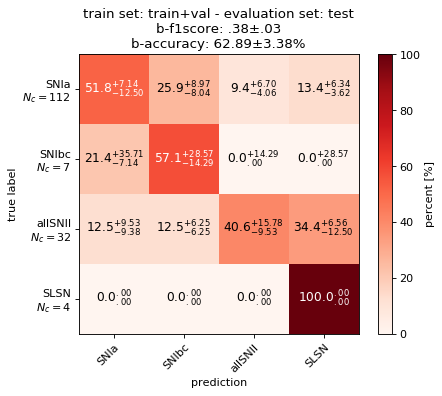

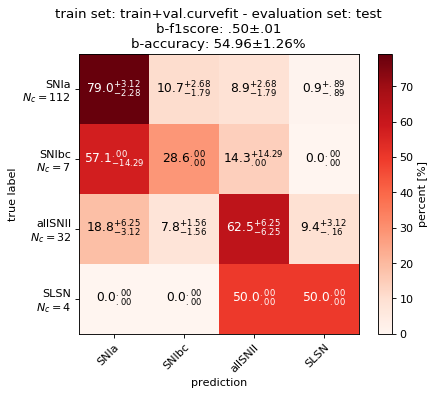

In [16]:
%load_ext autoreload
%autoreload 2
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
from flamingchoripan.datascience.statistics import XError

new_order_classes = ['SNIa', 'SNIbc', 'allSNII', 'SLSN']
for train_lcset_name in train_lcset_names:
#for train_lcset_name in ['train']:
    d = results[train_lcset_name]
    lcset_name = d[model_ids[0]]['lcset_name']
    class_names = d[model_ids[0]]['class_names']
    cms = [d[id]['cm'][None] for id in model_ids]
    f1score_xe = XError([d[id]['f1score'] for id in model_ids])
    title = f'train set: {train_lcset_name} - evaluation set: {lcset_name}\n'
    title += f'b-f1score: {f1score_xe}'
    cm_kwargs = {
        'title':title,
        'figsize':(6,5),
    }
    plot_custom_confusion_matrix(np.concatenate(cms, axis=0), class_names, new_order_classes, **cm_kwargs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
40
40


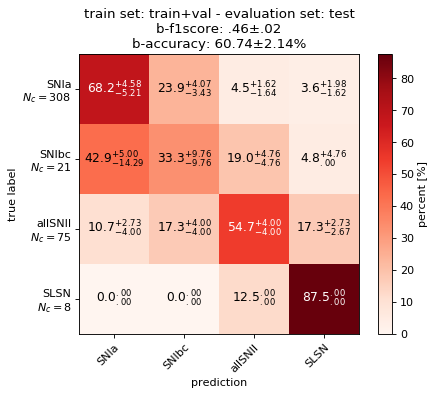

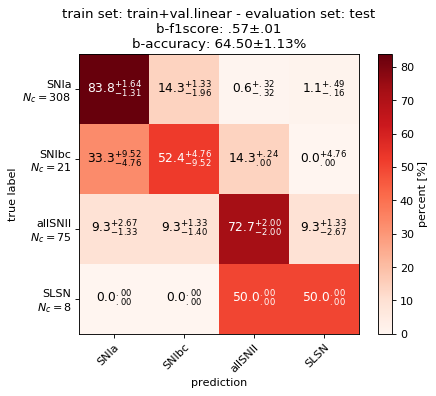

In [39]:
%load_ext autoreload
%autoreload 2
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
from flamingchoripan.datascience.statistics import XError

new_order_classes = ['SNIa', 'SNIbc', 'allSNII', 'SLSN']
for train_lcset_name in train_lcset_names:
#for train_lcset_name in ['train']:
    d = results[train_lcset_name]
    print(len(model_ids))
    lcset_name = d[model_ids[0]]['lcset_name']
    class_names = d[model_ids[0]]['class_names']
    cms = [d[id]['cm'][None] for id in model_ids]
    f1score_xe = XError([d[id]['f1score'] for id in model_ids])
    title = f'train set: {train_lcset_name} - evaluation set: {lcset_name}\n'
    title += f'b-f1score: {f1score_xe}'
    cm_kwargs = {
        'title':title,
        'figsize':(6,5),
    }
    plot_custom_confusion_matrix(np.concatenate(cms, axis=0), class_names, new_order_classes, **cm_kwargs)